In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (10, 3)
plt.rcParams['figure.dpi'] = 150

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1, np.cos(season_time*6*np.pi), 2/np.exp(9*season_time))

def add_seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def add_noise(time, noise_level=1, seed=None):
    """Adds white noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def generate_time_series(amplitude=50, noise_level=3):
    time = np.arange(4*365 + 1, dtype=np.float32)
    y_intercep, slope = 10, 0.005
    series = trend(time, slope) + y_intercep
    
    # add seasonality pattern
    series += add_seasonality(time, period=365, amplitude=amplitude)
    
    # add some noise
    series += add_noise(time, noise_level, seed=51)
    
    return time, series

def creat_window_dataset(series, window_size, batch_size, shuffle):
    """
    Creat time window as X training and predict Y
    Eg. If we want to predict yt based on previous 30 data, X.shape = 30
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle)
    dataset = dataset.map(lambda window: (window[: -1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

def train_val_split(time, series, time_step):
    return time[: time_step], series[: time_step], time[time_step:], series[time_step:]

In [4]:
class EarlyStoping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.001:
            print('Early stopping 0.001 reached. Training stopped!')
            self.model.stop_training = True

def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Dense(units=1)
    ])
    
    return model

def creat_model():
    tf.random.set_seed(51)
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
    
    return model

def compute_metrics(true_series, predicted_series):
    mse = tf.keras.metrics.mean_squared_error(true_series, predicted_series).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, predicted_series).numpy()
    
    return mse, mae

def model_forecast(model, series, window_size):
    """Forecast the future values"""
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [18]:
# Let's save the parameters of our time series in the dataclass
class PARAMETERS:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100 # on day 1100 the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 20 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 32 # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer

In [20]:
time, series = generate_time_series()
dataset = creat_window_dataset(series, PARAMETERS.WINDOW_SIZE, PARAMETERS.BATCH_SIZE, PARAMETERS.SHUFFLE_BUFFER_SIZE)
time_train, series_train, time_valid, series_valid = train_val_split(PARAMETERS.TIME, PARAMETERS.SERIES, PARAMETERS.SPLIT_TIME)

In [24]:
early_stopping = EarlyStoping()
model = creat_model()
history = model.fit(dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
46/46 [==============================] - 18s 183ms/step - loss: 8.7434 - mae: 9.2254
Epoch 2/20
46/46 [==============================] - 6s 135ms/step - loss: 7.3055 - mae: 7.7848
Epoch 3/20
46/46 [==============================] - 6s 129ms/step - loss: 7.3062 - mae: 7.7853
Epoch 4/20
46/46 [==============================] - 6s 126ms/step - loss: 7.3011 - mae: 7.7802
Epoch 5/20
46/46 [==============================] - 6s 126ms/step - loss: 7.3030 - mae: 7.7829
Epoch 6/20
46/46 [==============================] - 6s 125ms/step - loss: 7.3003 - mae: 7.7799
Epoch 7/20
46/46 [==============================] - 6s 125ms/step - loss: 7.2968 - mae: 7.7756
Epoch 8/20
46/46 [==============================] - 6s 125ms/step - loss: 7.2968 - mae: 7.7750
Epoch 9/20
46/46 [==============================] - 6s 127ms/step - loss: 7.3010 - mae: 7.7790
Epoch 10/20
46/46 [==============================] - 6s 127ms/step - loss: 7.2940 - mae: 7.7734
Epoch 11/20
46/46 [=============================

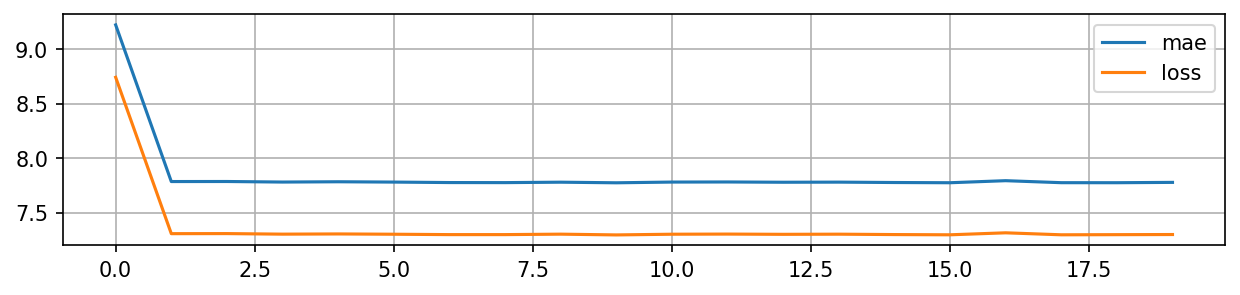

In [25]:
# plot MAE and loss
plt.figure(figsize=(10, 2))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

46/46 [==============================] - 6s 73ms/step


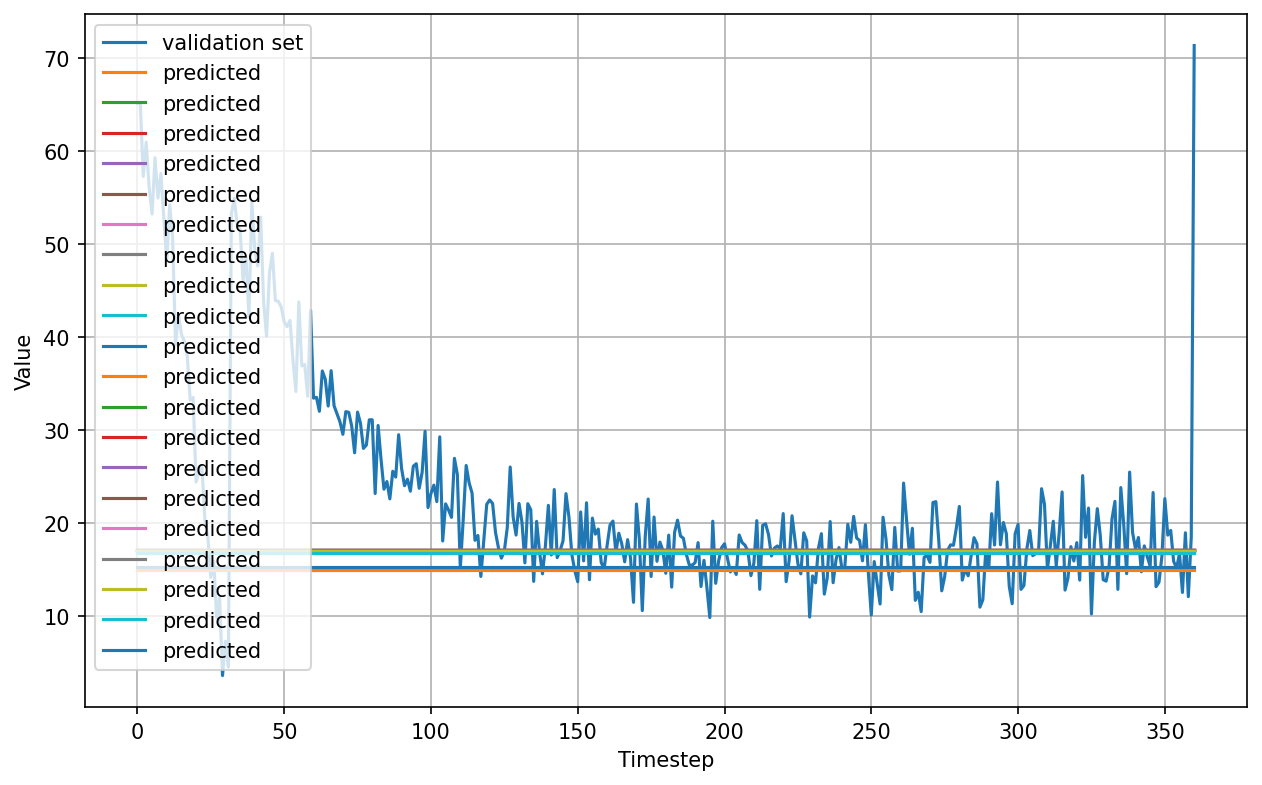

In [26]:
# Prediction on the whole series
all_forecast = model_forecast(model, PARAMETERS.SERIES, PARAMETERS.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[PARAMETERS.SPLIT_TIME - PARAMETERS.WINDOW_SIZE:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

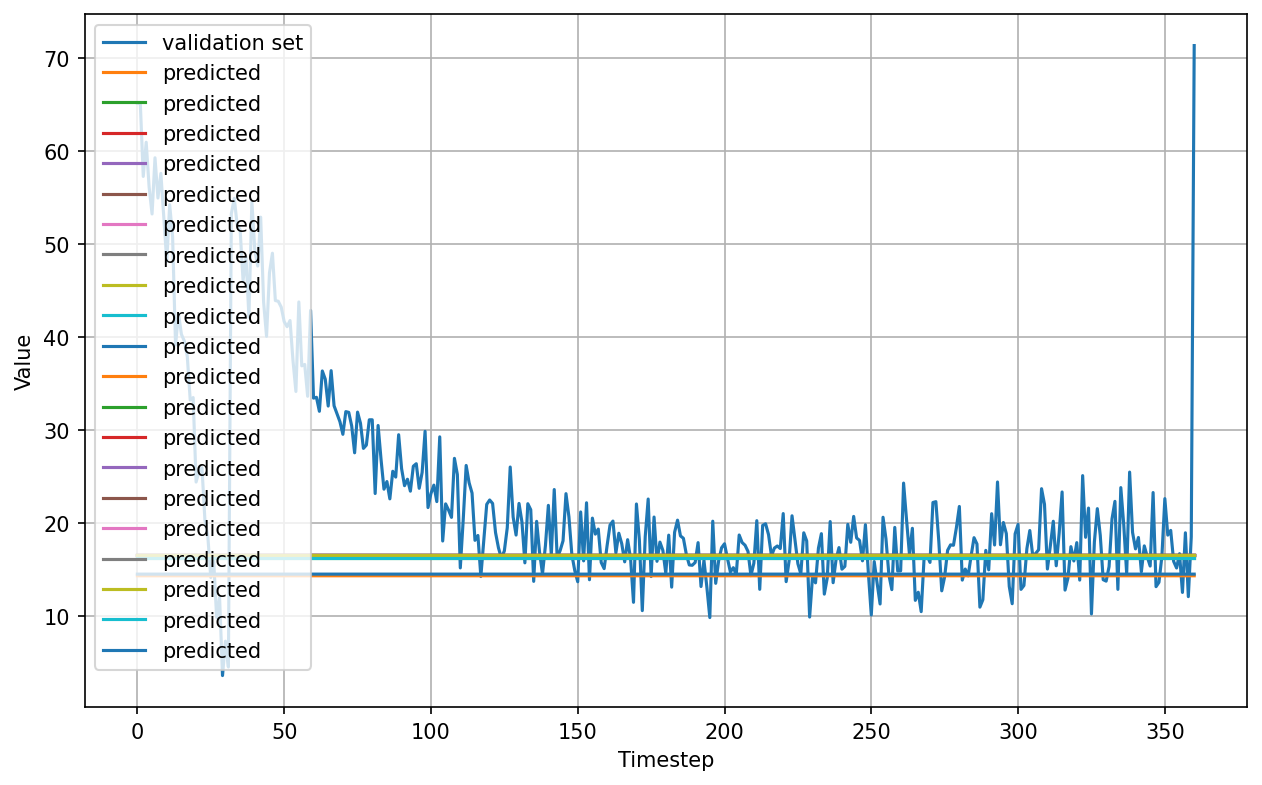

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(val_y, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()